In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random as rn
import time
from sklearn import metrics

def estimateGaussian(x):
    m, n = x.shape
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    mu = (1/m)*np.nansum(x, axis=0)
    sigma2 = (1/(m-1))*np.nansum((x-mu)**2,axis=0)  
    return mu, sigma2

def normalized (x):
    minimum = np.min(x, axis = 0 )
    maximum = np.max(x, axis = 0 )
    return np.array([(x[i,:] - minimum)/(maximum - minimum) for i in range(len(x))])

def add_random ( dataset, sigma2 ):
    dataset = np.array([dataset[i,:] + rn.uniform(0, sigma2**(1/6)) for i in range(len(dataset))])
    return dataset

def add_n_years (dataset, n_year):
    new_dataset = dataset
    sigma2 = estimateGaussian(dataset)[1]
    for i in range(n_year):
        start_time = time.time()
        new_dataset = np.concatenate((new_dataset, add_random(dataset, sigma2)), axis=0)
        print('Loading', str(i), " - year ---------- %s seconds ---" % (time.time() - start_time))
    return new_dataset

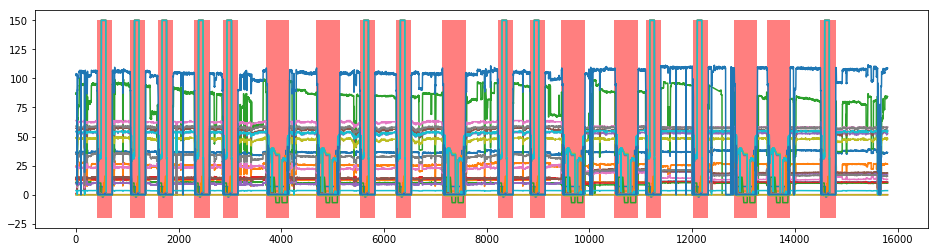

In [2]:
# Read and formatting prepeared data for learning
df= pd.read_excel('Data_new_21_changed.xlsx', columns = ['Date & Time','FI_C771J1.PV','FI_C771J2.PV','HC_C771L.OP','HC_C771J1.OP','TI_C771T11.PV','TI_C771T21.PV','TI_C771T31.PV','TI_C771T41.PV','TI_C771T51.PV','TI_C771T61.PV','VI_C771X11.PV','VI_C771X21.PV','VI_C771W11.PV','VI_C771W21.PV','VI_C771V11.PV','VI_C771V21.PV','VI_C771U11.PV','VI_C771U21.PV','PI_C771C2.PV','PI_C771H.PV','IT_C771F'])
X = (np.array(df.fillna(0))[:,1:-1])
y = df['y']

# Plotting data with 50/50 classes
plt.figure(figsize=(16,4))
plt.plot(X)
plt.fill_between(df.index, -20, 150, where=y==1, facecolor='red', alpha = 0.5)
plt.show()

In [3]:
# Calulate data with random for extra n years
n = 50 # Add year for data
X_n_years = add_n_years(X, n-1)
y_n_years = np.array(list(y)*n)

Loading 0  - year ---------- 0.5118594169616699 seconds ---
Loading 1  - year ---------- 0.7357840538024902 seconds ---
Loading 2  - year ---------- 0.8826193809509277 seconds ---
Loading 3  - year ---------- 0.507990837097168 seconds ---
Loading 4  - year ---------- 0.478851318359375 seconds ---
Loading 5  - year ---------- 0.488724946975708 seconds ---
Loading 6  - year ---------- 0.5620687007904053 seconds ---
Loading 7  - year ---------- 0.5435030460357666 seconds ---
Loading 8  - year ---------- 0.5337562561035156 seconds ---
Loading 9  - year ---------- 0.6494615077972412 seconds ---
Loading 10  - year ---------- 0.6359727382659912 seconds ---
Loading 11  - year ---------- 0.6028060913085938 seconds ---
Loading 12  - year ---------- 0.6026947498321533 seconds ---
Loading 13  - year ---------- 0.5549979209899902 seconds ---
Loading 14  - year ---------- 0.5022873878479004 seconds ---
Loading 15  - year ---------- 0.5342390537261963 seconds ---
Loading 16  - year ---------- 0.53649

c:\users\karli\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score:  98.35009805782249


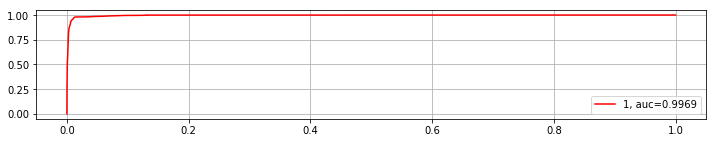

Gini:  0.9938


In [4]:
# Building model
X_train, X_test, y_train, y_test = train_test_split( X_n_years, y_n_years, test_size = 0.2)
lm = linear_model.LogisticRegression()
model = lm.fit ( X_train, y_train )
prediction = lm.predict ( X_test )
print('Score: ', model.score( X_test, y_test) *100)

# Estimation our model on validation data
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
y_pred_proba = lm.predict_proba(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

# Plotting AUC for visualization errors
plt.figure(figsize=(12,2))
plt.plot(fpr,tpr,'r', label="1, auc="+str(round(auc,4)))
plt.grid()
plt.legend(loc=4)
plt.show()
print('Gini: ', str(2*(round(auc,4)) -1))

In [5]:
# Downloading real data for testing
df_test= pd.read_excel('Data_new_21.xlsx', columns = ['Date & Time','FI_C771J1.PV','FI_C771J2.PV','HC_C771L.OP','HC_C771J1.OP','TI_C771T11.PV','TI_C771T21.PV','TI_C771T31.PV','TI_C771T41.PV','TI_C771T51.PV','TI_C771T61.PV','VI_C771X11.PV','VI_C771X21.PV','VI_C771W11.PV','VI_C771W21.PV','VI_C771V11.PV','VI_C771V21.PV','VI_C771U11.PV','VI_C771U21.PV','PI_C771C2.PV','PI_C771H.PV','IT_C771F'])
X_original = (np.array(df_test.fillna(0))[:,1:-1])
y__original = df_test['y']
pred_y = model.predict(X_original)

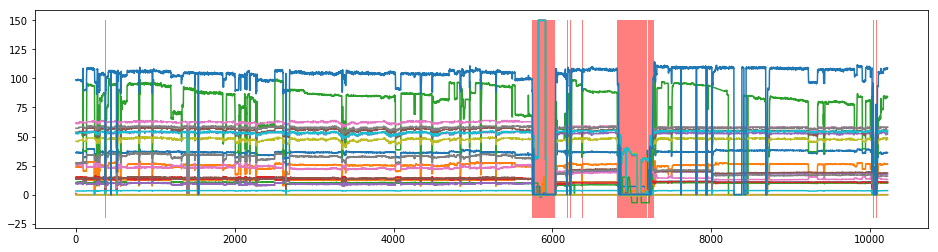

In [6]:
# Plotting resul
plt.figure(figsize=(16,4))
plt.plot(X_original)
plt.fill_between(df_test.index, -20, 150, where=pred_y==1, facecolor='red', alpha = 0.5)
plt.show()